<a href="https://colab.research.google.com/github/Immaczx/SemanticSegmentation/blob/master/Notebooks/DAUnetSegmentationTomatoSeeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/Immaczx/SemanticSegmentation.git

fatal: destination path 'SemanticSegmentation' already exists and is not an empty directory.


In [ ]:
from SemanticSegmentation import utils
import os
import math as m
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gcpds.image_segmentation.datasets.segmentation import TomatoSeeds
from gcpds.image_segmentation.losses import DiceCoefficient
from gcpds.image_segmentation.metrics import Jaccard, Sensitivity, Specificity
from gcpds.image_segmentation.metrics import DiceCoefficientMetric
from gcpds.image_segmentation.models import unet_baseline, fcn_baseline, segnet_baseline, res_unet_baseline

In [ ]:
# from tensorflow.keras import layers

IMG_SIZE=256
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

def preprocess(img,mask):
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))#Ch 1: Seed, Ch 2: No germinate, Ch 3: germinate
    mask = tf.cast(mask>0, tf.float32)
    mask = mask[...,0][..., None]
    return img,mask

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    seed = rng.make_seeds(2)[0]
    image, label = augment((inputs, labels), seed)
    return inputs, labels

def augment(image_label, seed):
  image, label = image_label
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  # Random contrast
  image = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label
# Create a wrapper function for updating seeds.

In [ ]:
image_size=256
out_channels = 1

model = unet_baseline(input_shape=(image_size,image_size,3), out_channels=out_channels)
model.compile(loss=DiceCoefficient(), optimizer='Adam', metrics=[DiceCoefficientMetric(), Jaccard(), Sensitivity(), Specificity()])

 Number of images for Partition 1: 68
 Number of images for Partition 2: 18
 Number of images for Partition 3: 10
1/1 [==============================] - 0s 64ms/step - loss: -0.9244 - DiceCoefficientMetric: -0.9244 - Jaccard: 0.8651 - Sensitivity: 0.8932 - Specificity: 0.9993


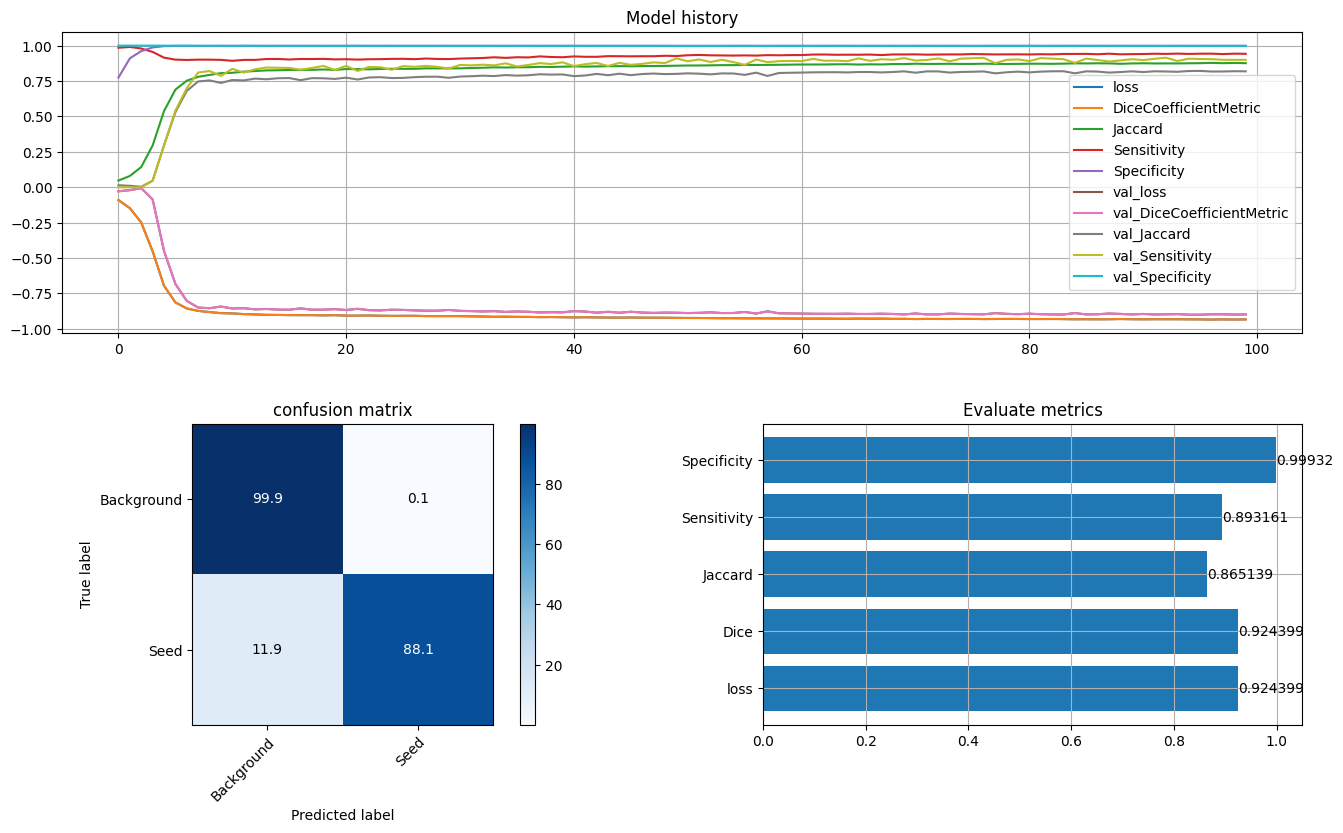

 Number of images for Partition 1: 68
 Number of images for Partition 2: 18
 Number of images for Partition 3: 10
1/1 [==============================] - 0s 56ms/step - loss: -0.9395 - DiceCoefficientMetric: -0.9395 - Jaccard: 0.8869 - Sensitivity: 0.9440 - Specificity: 0.9990


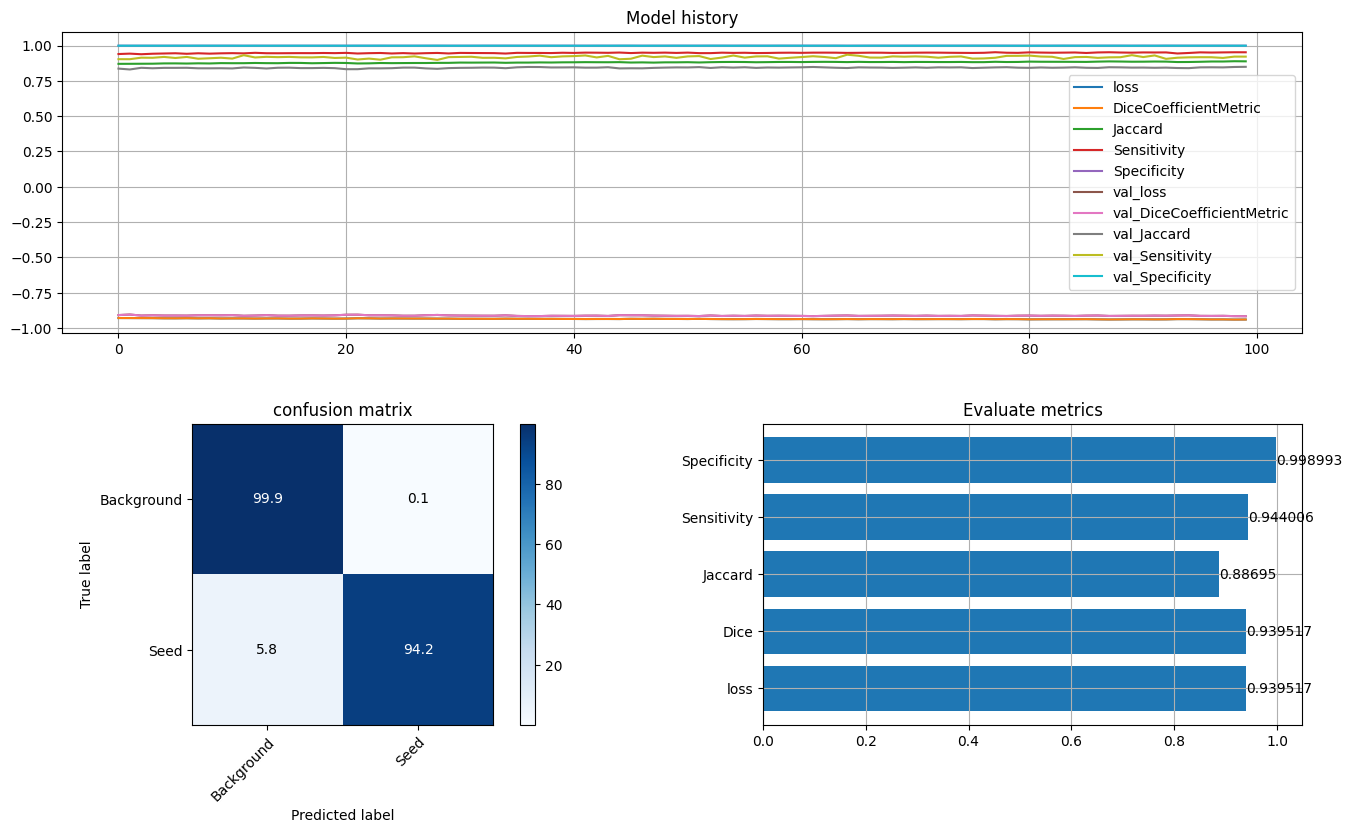

 Number of images for Partition 1: 68
 Number of images for Partition 2: 18
 Number of images for Partition 3: 10
1/1 [==============================] - 0s 58ms/step - loss: -0.9246 - DiceCoefficientMetric: -0.9246 - Jaccard: 0.8622 - Sensitivity: 0.9408 - Specificity: 0.9986


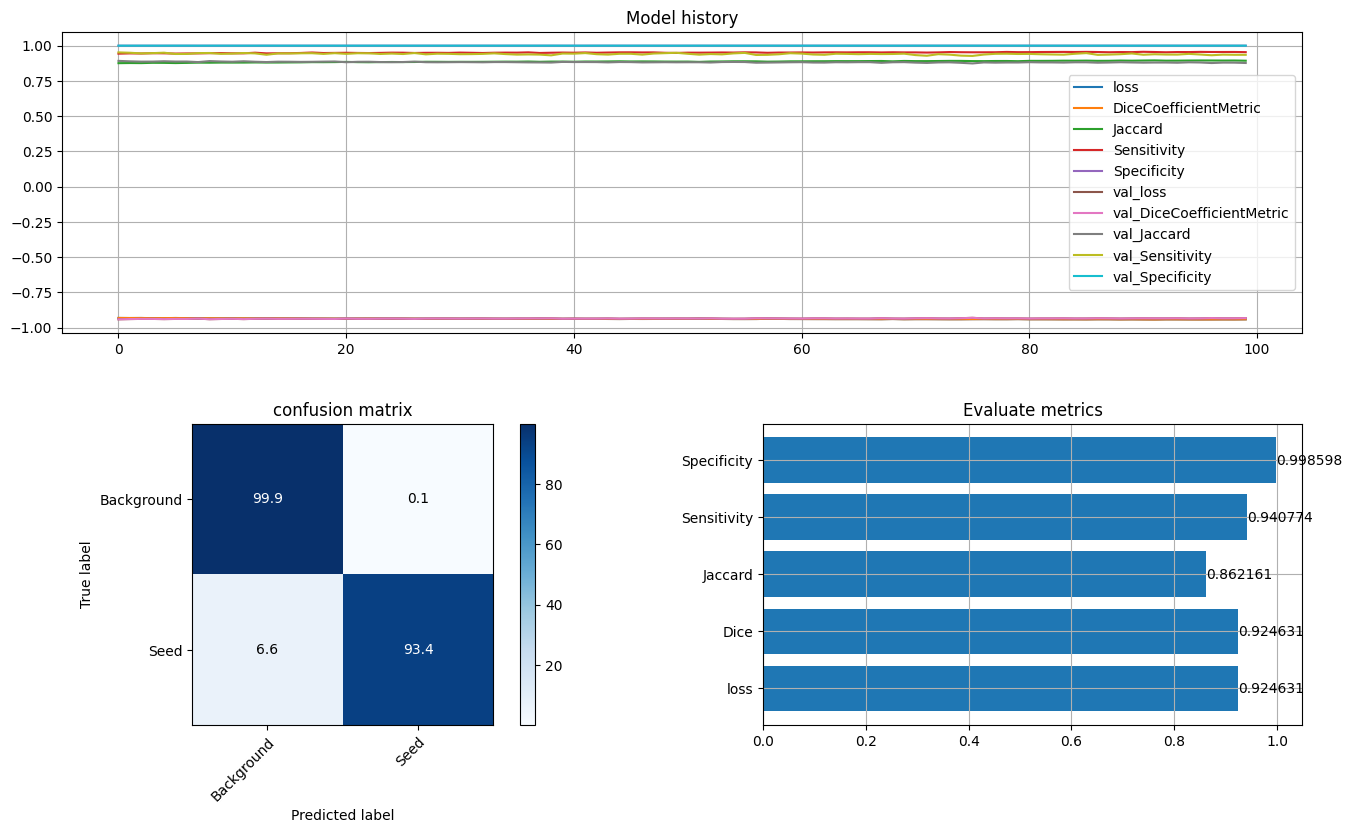

 Number of images for Partition 1: 68
 Number of images for Partition 2: 18
 Number of images for Partition 3: 10
1/1 [==============================] - 0s 63ms/step - loss: -0.9252 - DiceCoefficientMetric: -0.9252 - Jaccard: 0.8619 - Sensitivity: 0.9441 - Specificity: 0.9985


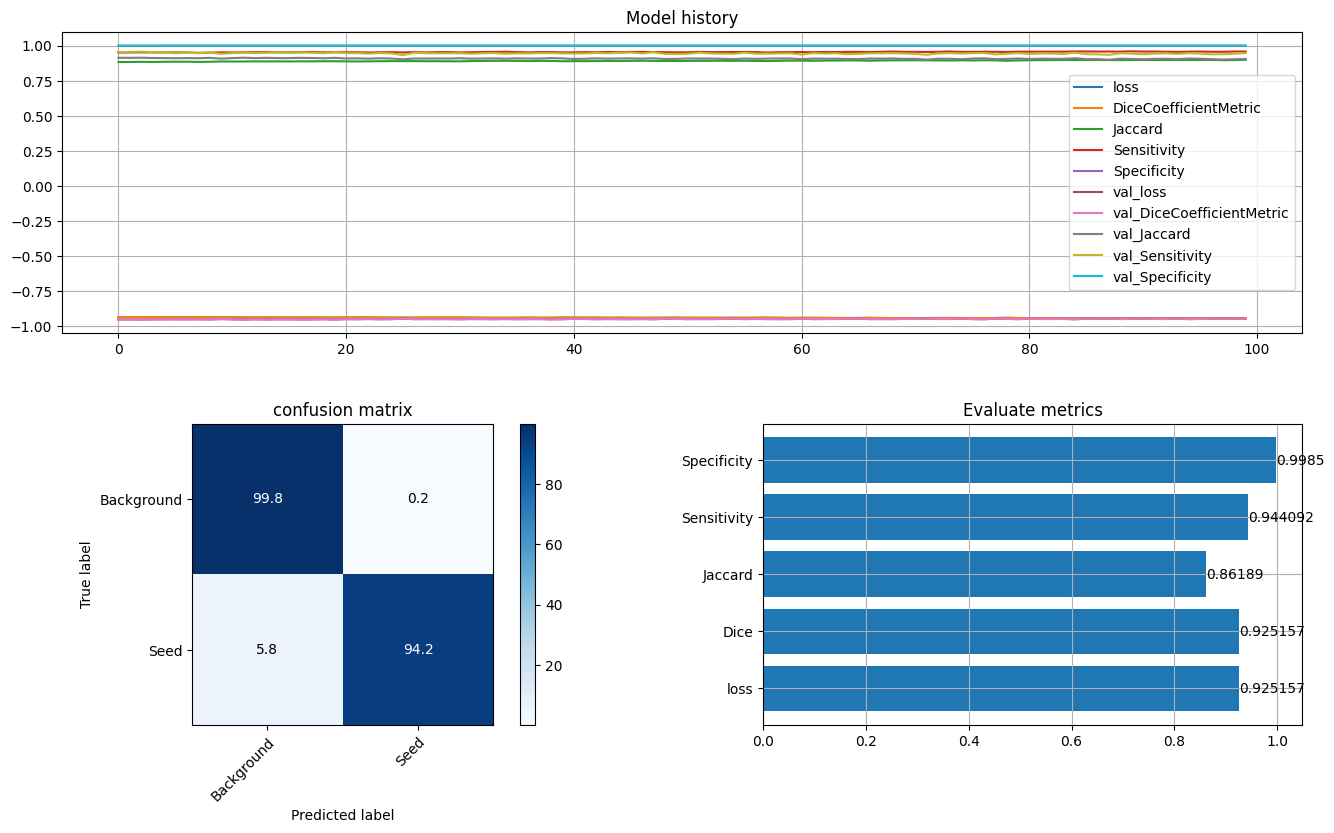

 Number of images for Partition 1: 68
 Number of images for Partition 2: 18
 Number of images for Partition 3: 10
1/1 [==============================] - 0s 69ms/step - loss: -0.9354 - DiceCoefficientMetric: -0.9354 - Jaccard: 0.8798 - Sensitivity: 0.9310 - Specificity: 0.9990


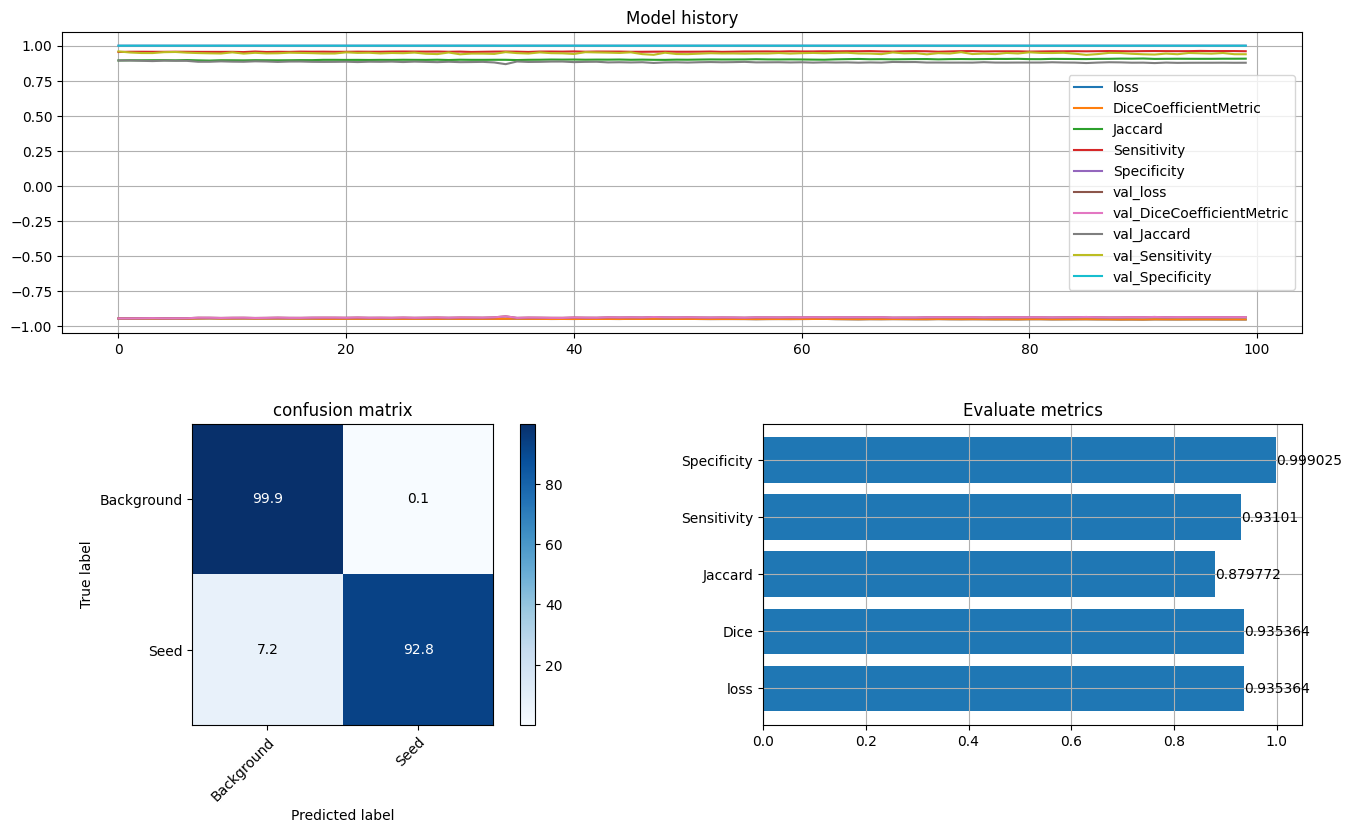

In [ ]:
for i in range(5):
  num = np.random.randint(0, 100)
  dataset = TomatoSeeds(split=[0.1,0.2], seed = num)
  train,val,test = dataset()

  train = train.map(lambda x,y,id:preprocess(x,y))
  train = train.batch(1)
  val = val.map(lambda x,y,id:preprocess(x,y))
  val = val.batch(1)
  test = test.map(lambda x,y,id:preprocess(x,y))
  test = test.batch(1)

  train = train.cache()
  val = val.cache()
  test = test.cache()

  train_ds = (
    train
    .shuffle(1000)
    .map(Augment(), num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
  )

  train_da = train.cache()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  model_history = model.fit(train_da,validation_data=val, epochs=100, verbose=0)
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  fig = plt.figure(figsize=(16,9))

  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, :])
  ax2 = fig.add_subplot(gs[1, :-1])
  ax3 = fig.add_subplot(gs[1:, -1])

  for i in model_history.history:
    ax1.plot(model_history.history[i],label=i)
  ax1.set_title('Model history')
  ax1.legend()
  ax1.grid()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  img_test = tf.zeros((0, 256, 256, 3), dtype=tf.float32)
  mask_test = tf.zeros((0, 256, 256,1), dtype=tf.float32)

  for img, mask in test:
      img_test = tf.concat([img_test, img], axis=0)
      mask_test = tf.concat([mask_test, mask], axis=0)
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  mask_pred = model.predict(img_test)
  mask_pred = np.where(mask_pred > .5, 1, 0)
  evaluate_history = model.evaluate(img_test, mask_test)
  bars = ax3.barh(["loss","Dice","Jaccard","Sensitivity","Specificity"],np.abs(evaluate_history))
  ax3.bar_label(bars)
  ax3.set_title('Evaluate metrics')
  ax3.grid()

  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  # Then, convert the predicted and ground truth masks to single-dimensional arrays
  pred_flat = tf.reshape(mask_pred, [-1])
  true_flat = tf.reshape(mask_test, [-1])

  # Plot the confusion matrix
  utils.plot_confusion_matrix(true_flat, pred_flat, classes=['Background','Seed'], ax = ax2)
  ax2.set_title('confusion matrix')

  # Ajustar los espacios entre los subplots
  fig.subplots_adjust(wspace=0.3, hspace=0.3)

  # Mostrar la figura
  plt.show()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  del train, val, test, dataset
  tf.keras.backend.clear_session()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------